In [1]:
GOOGLE = False
if GOOGLE:
    from google.colab import drive
    drive.mount('/content/drive')

In [2]:
# @title import
import sys

if GOOGLE:
    sys.path.append('/content/drive/MyDrive/torch_code/')
from shared.data_loader import *
from shared.utils import *

In [3]:
# @title GPU code
import torch
import torch.nn.functional as F

# Define the device to use for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

Please set GPU via Edit -> Notebook Settings.


In [4]:
# @title EEG DATA
import os
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
import pandas as pd

class EEG_Data(Dataset):

    def __init__(self, root_dir, split, preprocess=lambda x,y:train_data_prep(x,y,2,2,True), transform=None, label_dict=None):
        """
        Initialize the eeg dataset with the root directory for the images,
        the split (train/val/test), an optional data transformation,
        and an optional label dictionary.

        Args:
            root_dir (str): Root directory for the eeg images.
            split (str): Split to use ('train', 'val', or 'test').
            transform (callable, optional): Optional data transformation to apply to the images.
            label_dict (dict, optional): Optional dictionary mapping integer labels to class names.
        """
        assert split in ['train', 'val', 'test']
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.datastorch = []
        self.labels = []
        self.label_dict = ["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"]

        ################# Your Implementations #################################
        if self.split == 'train':
            # First generating the training and validation indices using random splitting
            X_train_valid = np.load(self.root_dir+"X_train_valid.npy")
            y_train_valid = np.load(self.root_dir+"y_train_valid.npy")

            np.random.seed(0)
            data_length = len(X_train_valid)

            ind_valid = np.random.choice(data_length, int(data_length*0.1), replace=False)
            ind_train = np.array(list(set(range(data_length)).difference(set(ind_valid))))

            # Creating the training and validation sets using the generated indices
            (x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
            (y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

            if preprocess is not None:
                x_train,y_train = preprocess(x_train,y_train)

            self.datas = torch.from_numpy(x_train)
            self.labels = [int(i-769) for i in torch.from_numpy(y_train)]

        if self.split == 'val':
            # First generating the training and validation indices using random splitting
            X_train_valid = np.load(self.root_dir+"X_train_valid.npy")
            y_train_valid = np.load(self.root_dir+"y_train_valid.npy")

            data_length = len(X_train_valid)

            np.random.seed(0)
            ind_valid = np.random.choice(data_length, int(data_length*0.1), replace=False)
            ind_train = np.array(list(set(range(data_length)).difference(set(ind_valid))))

            # Creating the training and validation sets using the generated indices
            (x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
            (y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

            if preprocess is not None:
                x_valid,y_valid = preprocess(x_valid,y_valid)

            self.datas = torch.from_numpy(x_valid)
            self.labels = [int(i-769) for i in torch.from_numpy(y_valid)]

        if self.split == 'test':
            x_test = np.load(self.root_dir+"X_test.npy")
            # x_test = test_data_prep(x_test_og)  # (2115, 1)  vals from 0-8 for participant
            if preprocess is not None:
                x_test = preprocess(x_test)
            y_test = np.load(self.root_dir+"y_test.npy")  # (443, 1)
            self.datas = torch.from_numpy(x_test)
            self.labels = [int(i-769) for i in torch.from_numpy(y_test)]

        ################# End of your Implementations ##########################

    def __len__(self):
        """
        Return the number of images in the dataset.

        Returns:
            int: Number of images in the dataset.
        """
        dataset_len = 0
        ################# Your Implementations #################################
        # Return the number of images in the dataset
        dataset_len = len(self.datas)
        ################# End of your Implementations ##########################
        return dataset_len

    def __getitem__(self, idx):
        """
        R10140    idx (int): Index of the image to retrieve.

        Returns:
            tuple: Tuple containing the image and its label.
        """
        ################# Your Implementations #################################
        # Load and preprocess image using self.root_dir,
        # self.filenames[idx], and self.transform (if specified)

        data = self.datas[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(data)
        ################# End of your Implementations ##########################
        return data, label

In [5]:
# @title Convolution

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

class ConvBlock(nn.Module):
    def __init__(self, input_size, output_size, kernel_size, dropout=0.6):
        super().__init__()
        padding = (kernel_size-1)//2
        self.conv_block = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=output_size, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, padding=1),
            nn.BatchNorm1d(output_size),
            nn.Dropout(dropout)
        )
    def forward(self, x, **kwargs):
        # keey the residual connection here
        return self.conv_block.forward(x)

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 3, downsample=False, dropout=0.6):
        '''
        Initialize a basic residual block.
        Depending on whether downsample is True, there are two types of basic blocks in Resnet 18,
        one to downsample the input and the other maintains the same size.
        You can use Pytorch's functions.

        Input and output shapes of each layer:
        1) conv1 (3*3 kernel, no bias): (batch_size, in_channels, H, W) -> (batch_size, out_channels, H, W) if downsample=False
           conv1 (3*3 kernel, no bias): (batch_size, in_channels, H, W) -> (batch_size, out_channels, H//2, W//2) if downsample=True, with stride of 2
        2) conv2 (3*3 kernel, no bias): (batch_size, out_channels, H, W) -> (batch_size, out_channels, H, W)
        3) conv3 (optional) if downsample=True (1*1 kernel, no bias): (batch_size, in_channels, H, W) -> (batch_size, out_channels, H//2, W//2) with stride of 2
        '''
        super().__init__()
        ################# Your Implementations #################################
        self.downsample = downsample
        if (in_channels != out_channels):
           self.downsample = True
        self.kernel_size = kernel_size
        self.dropout = dropout
        # self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, bias=False, padding=1) #(128 - 3 + 2*1)//2 + 1
        self.conv2 = nn.Sequential(
                        nn.Conv1d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias=False),
                        nn.BatchNorm1d(out_channels))
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.bn3 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.relu2 = nn.ReLU()
        if self.downsample:
          self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False) #(128 - 3 + 2*1)//2 + 1
          self.conv3 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, bias=False) #(128 - 3 + 2*1)//2 + 1
        else:
          self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False) #(128 - 3 + 2*1)//2 + 1

        ################# End of your Implementations ##########################

    def forward(self, x):
        """
        Forward pass of the basic residual block.
        The input tensor 'x' should pass through the following layers:
        1) conv1: (batch_size, in_channels, H, W) -> (batch_size, out_channels, H, W)
           conv1: (batch_size, in_channels, H, W) -> (batch_size, out_channels, H//2, W//2) if downsample=True
        2) Apply batch normalization after conv1.
        3) Apply relu activation.
        4) conv2: (batch_size, out_channels, H, W) -> (batch_size, out_channels, H, W)
        5) Apply batch normalization after conv2.
        6) (Optional) if downsample=True, conv3: (batch_size, in_channels, H, W) -> (batch_size, out_channels, H//2, W//2) on the original input
        7) (Optional) if downsample=True, apply batch normalization after conv3.
        8) Add the residual value to the original input
        9) Apply relu activation in the end.
        """
        ################# Your Implementations #################################
        # TODO: Implement the forward pass of the basic residual block.
        og=x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.downsample:
          og = self.conv3(og)
          og = self.bn3(og)
        x += og
        x =self.relu2(x)
        x = nn.Dropout(self.dropout)(x)
        ################# End of your Implementations ##########################
        return x

fc_block = lambda i, o : nn.Linear(i,o)




In [6]:
# This is EEGNet from https://arxiv.org/abs/1611.08024

class EEGNet(nn.Module):
    def __init__(self, cutoff):
        super(EEGNet, self).__init__()

        self.F1 = 8
        self.F2 = 16
        self.D = 2

        # Conv2d(in,out,kernel,stride,padding,bias)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, self.F1, (1, 64), padding=(0, 32), bias=False),
            nn.BatchNorm2d(self.F1)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(self.F1, self.D*self.F1, (18, 1), groups=self.F1, bias=False),
            nn.BatchNorm2d(self.D*self.F1),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(0.5)
        )

        self.Conv3 = nn.Sequential(
            nn.Conv2d(self.D*self.F1, self.D*self.F1, (1, 16), padding=(0, 8), groups=self.D*self.F1, bias=False),
            nn.Conv2d(self.D*self.F1, self.F2, (1, 1), bias=False),
            nn.BatchNorm2d(self.F2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(0.5)
        )


        if cutoff is not None:
            cutoff_map ={
                100 :80,
                150:160,
                200:240,
                250:320,
                300:320,
                350:400,
                400:480,
                450:560,
                500:560,
                550:640,
                600:720,
                650:800,
                700:880,
                750:880,
                800:960,
                850:1040,
                900:1120,
                950:1200,
                1000:1200
            }
            assert(cutoff in cutoff_map.keys())
            self.flatten = nn.Flatten(start_dim=1)
            self.classifier = nn.Linear(cutoff_map[timestop], 4, bias=True)

        else:
            self.flatten = nn.Flatten(start_dim=1)
            self.classifier = nn.Linear(240, 4, bias=True)

    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.Conv3(x)

        x = self.flatten(x)
        x = self.classifier(x)
        return x


In [11]:
all_result = {}

Shape of X after subsampling and concatenating: (7616, 22, 50)
Shape of Y: (7616,)
Shape of X after subsampling and concatenating: (844, 22, 50)
Shape of Y: (844,)
val split:  844
train split:  7616
torch.Size([1, 22, 50])
torch.Size([1, 18, 50])


Epoch 1/30: 100%|██████████| 119/119 [00:01<00:00, 85.66it/s, loss=1.37]


Validation set: Average loss = 1.3971, Accuracy = 0.2227
Training set: Average loss = 1.3863, Accuracy = 0.2646


Epoch 2/30: 100%|██████████| 119/119 [00:01<00:00, 77.96it/s, loss=1.41]


Validation set: Average loss = 1.3971, Accuracy = 0.2239
Training set: Average loss = 1.3865, Accuracy = 0.2665


Epoch 3/30: 100%|██████████| 119/119 [00:01<00:00, 86.11it/s, loss=1.41]


Validation set: Average loss = 1.3976, Accuracy = 0.2216
Training set: Average loss = 1.3866, Accuracy = 0.2656


Epoch 4/30: 100%|██████████| 119/119 [00:01<00:00, 82.96it/s, loss=1.44]


Validation set: Average loss = 1.3971, Accuracy = 0.2227
Training set: Average loss = 1.3862, Accuracy = 0.2638


Epoch 5/30: 100%|██████████| 119/119 [00:01<00:00, 84.20it/s, loss=1.41]


Validation set: Average loss = 1.3976, Accuracy = 0.2192
Training set: Average loss = 1.3866, Accuracy = 0.2647


Epoch 6/30: 100%|██████████| 119/119 [00:01<00:00, 82.03it/s, loss=1.47]


Validation set: Average loss = 1.3974, Accuracy = 0.2216
Training set: Average loss = 1.3865, Accuracy = 0.2655


Epoch 7/30: 100%|██████████| 119/119 [00:01<00:00, 91.10it/s, loss=1.5] 


Validation set: Average loss = 1.3974, Accuracy = 0.2216
Training set: Average loss = 1.3865, Accuracy = 0.2652


Epoch 8/30: 100%|██████████| 119/119 [00:01<00:00, 90.16it/s, loss=1.46] 


Validation set: Average loss = 1.3971, Accuracy = 0.2204
Training set: Average loss = 1.3862, Accuracy = 0.2660


Epoch 9/30: 100%|██████████| 119/119 [00:01<00:00, 66.26it/s, loss=1.4] 


Validation set: Average loss = 1.3972, Accuracy = 0.2227
Training set: Average loss = 1.3863, Accuracy = 0.2662


Epoch 10/30: 100%|██████████| 119/119 [00:01<00:00, 67.00it/s, loss=1.45]


Validation set: Average loss = 1.3972, Accuracy = 0.2239
Training set: Average loss = 1.3864, Accuracy = 0.2650


Epoch 11/30: 100%|██████████| 119/119 [00:01<00:00, 71.50it/s, loss=1.45]


Validation set: Average loss = 1.3970, Accuracy = 0.2204
Training set: Average loss = 1.3865, Accuracy = 0.2665


Epoch 12/30: 100%|██████████| 119/119 [00:02<00:00, 58.88it/s, loss=1.4] 


Validation set: Average loss = 1.3973, Accuracy = 0.2204
Training set: Average loss = 1.3863, Accuracy = 0.2651


Epoch 13/30: 100%|██████████| 119/119 [00:01<00:00, 68.40it/s, loss=1.41]


Validation set: Average loss = 1.3971, Accuracy = 0.2216
Training set: Average loss = 1.3862, Accuracy = 0.2676


Epoch 14/30: 100%|██████████| 119/119 [00:01<00:00, 69.84it/s, loss=1.42]


Validation set: Average loss = 1.3967, Accuracy = 0.2263
Training set: Average loss = 1.3859, Accuracy = 0.2662


Epoch 15/30: 100%|██████████| 119/119 [00:01<00:00, 64.71it/s, loss=1.43]


Validation set: Average loss = 1.3969, Accuracy = 0.2216
Training set: Average loss = 1.3864, Accuracy = 0.2665


Epoch 16/30: 100%|██████████| 119/119 [00:01<00:00, 73.09it/s, loss=1.44]


Validation set: Average loss = 1.3970, Accuracy = 0.2239
Training set: Average loss = 1.3862, Accuracy = 0.2659


Epoch 17/30: 100%|██████████| 119/119 [00:01<00:00, 62.27it/s, loss=1.37]


Validation set: Average loss = 1.3975, Accuracy = 0.2204
Training set: Average loss = 1.3866, Accuracy = 0.2654


Epoch 18/30: 100%|██████████| 119/119 [00:01<00:00, 70.15it/s, loss=1.4] 


Validation set: Average loss = 1.3976, Accuracy = 0.2180
Training set: Average loss = 1.3864, Accuracy = 0.2658


Epoch 19/30: 100%|██████████| 119/119 [00:01<00:00, 82.13it/s, loss=1.39]


Validation set: Average loss = 1.3969, Accuracy = 0.2227
Training set: Average loss = 1.3862, Accuracy = 0.2654


Epoch 20/30: 100%|██████████| 119/119 [00:01<00:00, 74.87it/s, loss=1.43]


Validation set: Average loss = 1.3970, Accuracy = 0.2204
Training set: Average loss = 1.3863, Accuracy = 0.2656


Epoch 21/30: 100%|██████████| 119/119 [00:01<00:00, 71.47it/s, loss=1.39]


Validation set: Average loss = 1.3972, Accuracy = 0.2192
Training set: Average loss = 1.3864, Accuracy = 0.2652


Epoch 22/30: 100%|██████████| 119/119 [00:01<00:00, 67.18it/s, loss=1.38]


Validation set: Average loss = 1.3968, Accuracy = 0.2239
Training set: Average loss = 1.3862, Accuracy = 0.2664


Epoch 23/30: 100%|██████████| 119/119 [00:01<00:00, 66.74it/s, loss=1.33]


Validation set: Average loss = 1.3972, Accuracy = 0.2227
Training set: Average loss = 1.3863, Accuracy = 0.2681


Epoch 24/30: 100%|██████████| 119/119 [00:01<00:00, 64.66it/s, loss=1.43]


Validation set: Average loss = 1.3973, Accuracy = 0.2216
Training set: Average loss = 1.3864, Accuracy = 0.2651


Epoch 25/30: 100%|██████████| 119/119 [00:01<00:00, 69.71it/s, loss=1.37]


Validation set: Average loss = 1.3971, Accuracy = 0.2239
Training set: Average loss = 1.3863, Accuracy = 0.2659


Epoch 26/30: 100%|██████████| 119/119 [00:02<00:00, 56.28it/s, loss=1.44]


Validation set: Average loss = 1.3970, Accuracy = 0.2216
Training set: Average loss = 1.3861, Accuracy = 0.2664


Epoch 27/30: 100%|██████████| 119/119 [00:01<00:00, 64.55it/s, loss=1.41]


Validation set: Average loss = 1.3973, Accuracy = 0.2204
Training set: Average loss = 1.3865, Accuracy = 0.2655


Epoch 28/30: 100%|██████████| 119/119 [00:01<00:00, 69.29it/s, loss=1.41]


Validation set: Average loss = 1.3971, Accuracy = 0.2216
Training set: Average loss = 1.3863, Accuracy = 0.2642


Epoch 29/30: 100%|██████████| 119/119 [00:01<00:00, 67.30it/s, loss=1.4] 


Validation set: Average loss = 1.3974, Accuracy = 0.2192
Training set: Average loss = 1.3864, Accuracy = 0.2651


Epoch 30/30: 100%|██████████| 119/119 [00:01<00:00, 68.13it/s, loss=1.42]


Validation set: Average loss = 1.3971, Accuracy = 0.2239
Training set: Average loss = 1.3863, Accuracy = 0.2654


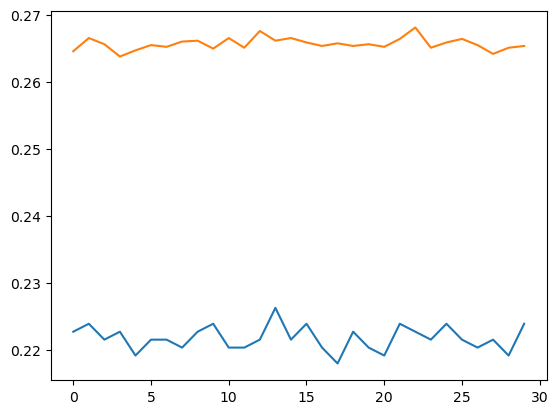

avg_loss 1.388399907520839
accuracy 0.27313769751693
Shape of X after subsampling and concatenating: (7616, 22, 75)
Shape of Y: (7616,)
Shape of X after subsampling and concatenating: (844, 22, 75)
Shape of Y: (844,)
val split:  844
train split:  7616
torch.Size([1, 22, 75])
torch.Size([1, 18, 75])


Epoch 1/30: 100%|██████████| 119/119 [00:02<00:00, 55.38it/s, loss=1.42]


Validation set: Average loss = 1.3942, Accuracy = 0.2405
Training set: Average loss = 1.3967, Accuracy = 0.2465


Epoch 2/30: 100%|██████████| 119/119 [00:02<00:00, 55.10it/s, loss=1.42]


Validation set: Average loss = 1.3946, Accuracy = 0.2464
Training set: Average loss = 1.3967, Accuracy = 0.2465


Epoch 3/30: 100%|██████████| 119/119 [00:02<00:00, 51.06it/s, loss=1.43]


Validation set: Average loss = 1.3943, Accuracy = 0.2500
Training set: Average loss = 1.3965, Accuracy = 0.2483


Epoch 4/30: 100%|██████████| 119/119 [00:02<00:00, 56.66it/s, loss=1.39]


Validation set: Average loss = 1.3943, Accuracy = 0.2417
Training set: Average loss = 1.3965, Accuracy = 0.2462


Epoch 5/30: 100%|██████████| 119/119 [00:02<00:00, 57.58it/s, loss=1.4] 


Validation set: Average loss = 1.3942, Accuracy = 0.2417
Training set: Average loss = 1.3968, Accuracy = 0.2462


Epoch 6/30: 100%|██████████| 119/119 [00:01<00:00, 59.52it/s, loss=1.43]


Validation set: Average loss = 1.3942, Accuracy = 0.2500
Training set: Average loss = 1.3964, Accuracy = 0.2470


Epoch 7/30: 100%|██████████| 119/119 [00:02<00:00, 58.36it/s, loss=1.45]


Validation set: Average loss = 1.3942, Accuracy = 0.2393
Training set: Average loss = 1.3966, Accuracy = 0.2461


Epoch 8/30: 100%|██████████| 119/119 [00:02<00:00, 58.31it/s, loss=1.42]


Validation set: Average loss = 1.3944, Accuracy = 0.2547
Training set: Average loss = 1.3965, Accuracy = 0.2478


Epoch 9/30: 100%|██████████| 119/119 [00:02<00:00, 53.25it/s, loss=1.45]


Validation set: Average loss = 1.3943, Accuracy = 0.2405
Training set: Average loss = 1.3968, Accuracy = 0.2453


Epoch 10/30: 100%|██████████| 119/119 [00:02<00:00, 53.13it/s, loss=1.37]


Validation set: Average loss = 1.3943, Accuracy = 0.2524
Training set: Average loss = 1.3964, Accuracy = 0.2483


Epoch 11/30: 100%|██████████| 119/119 [00:02<00:00, 44.49it/s, loss=1.46]


Validation set: Average loss = 1.3943, Accuracy = 0.2453
Training set: Average loss = 1.3967, Accuracy = 0.2478


Epoch 12/30: 100%|██████████| 119/119 [00:03<00:00, 36.30it/s, loss=1.47]


Validation set: Average loss = 1.3945, Accuracy = 0.2453
Training set: Average loss = 1.3967, Accuracy = 0.2466


Epoch 13/30: 100%|██████████| 119/119 [00:05<00:00, 22.58it/s, loss=1.38]


Validation set: Average loss = 1.3944, Accuracy = 0.2464
Training set: Average loss = 1.3966, Accuracy = 0.2475


Epoch 14/30: 100%|██████████| 119/119 [00:02<00:00, 42.33it/s, loss=1.42]


Validation set: Average loss = 1.3943, Accuracy = 0.2464
Training set: Average loss = 1.3965, Accuracy = 0.2472


Epoch 15/30: 100%|██████████| 119/119 [00:02<00:00, 40.43it/s, loss=1.4] 


Validation set: Average loss = 1.3944, Accuracy = 0.2429
Training set: Average loss = 1.3968, Accuracy = 0.2458


Epoch 16/30: 100%|██████████| 119/119 [00:02<00:00, 47.76it/s, loss=1.38]


Validation set: Average loss = 1.3945, Accuracy = 0.2441
Training set: Average loss = 1.3969, Accuracy = 0.2474


Epoch 17/30: 100%|██████████| 119/119 [00:03<00:00, 33.73it/s, loss=1.44]


Validation set: Average loss = 1.3944, Accuracy = 0.2500
Training set: Average loss = 1.3965, Accuracy = 0.2472


Epoch 18/30: 100%|██████████| 119/119 [00:04<00:00, 25.96it/s, loss=1.43]


Validation set: Average loss = 1.3946, Accuracy = 0.2488
Training set: Average loss = 1.3966, Accuracy = 0.2468


Epoch 19/30: 100%|██████████| 119/119 [00:03<00:00, 33.68it/s, loss=1.41]


Validation set: Average loss = 1.3944, Accuracy = 0.2453
Training set: Average loss = 1.3964, Accuracy = 0.2470


Epoch 20/30: 100%|██████████| 119/119 [00:04<00:00, 27.02it/s, loss=1.41]


Validation set: Average loss = 1.3942, Accuracy = 0.2429
Training set: Average loss = 1.3967, Accuracy = 0.2462


Epoch 21/30: 100%|██████████| 119/119 [00:04<00:00, 27.00it/s, loss=1.42]


Validation set: Average loss = 1.3945, Accuracy = 0.2488
Training set: Average loss = 1.3965, Accuracy = 0.2472


Epoch 22/30: 100%|██████████| 119/119 [00:03<00:00, 30.17it/s, loss=1.4] 


Validation set: Average loss = 1.3943, Accuracy = 0.2464
Training set: Average loss = 1.3965, Accuracy = 0.2474


Epoch 23/30: 100%|██████████| 119/119 [00:03<00:00, 32.39it/s, loss=1.4] 


Validation set: Average loss = 1.3943, Accuracy = 0.2524
Training set: Average loss = 1.3963, Accuracy = 0.2478


Epoch 24/30: 100%|██████████| 119/119 [00:04<00:00, 27.93it/s, loss=1.46]


Validation set: Average loss = 1.3943, Accuracy = 0.2488
Training set: Average loss = 1.3965, Accuracy = 0.2476


Epoch 25/30: 100%|██████████| 119/119 [00:03<00:00, 32.00it/s, loss=1.43]


Validation set: Average loss = 1.3944, Accuracy = 0.2464
Training set: Average loss = 1.3965, Accuracy = 0.2468


Epoch 26/30: 100%|██████████| 119/119 [00:03<00:00, 35.50it/s, loss=1.46]


Validation set: Average loss = 1.3943, Accuracy = 0.2429
Training set: Average loss = 1.3967, Accuracy = 0.2458


Epoch 27/30: 100%|██████████| 119/119 [00:03<00:00, 35.06it/s, loss=1.47]


Validation set: Average loss = 1.3944, Accuracy = 0.2488
Training set: Average loss = 1.3964, Accuracy = 0.2466


Epoch 28/30: 100%|██████████| 119/119 [00:03<00:00, 32.57it/s, loss=1.39]


Validation set: Average loss = 1.3944, Accuracy = 0.2464
Training set: Average loss = 1.3965, Accuracy = 0.2474


Epoch 29/30: 100%|██████████| 119/119 [00:04<00:00, 28.74it/s, loss=1.51]


Validation set: Average loss = 1.3944, Accuracy = 0.2476
Training set: Average loss = 1.3965, Accuracy = 0.2466


Epoch 30/30: 100%|██████████| 119/119 [00:03<00:00, 32.44it/s, loss=1.43]


Validation set: Average loss = 1.3940, Accuracy = 0.2429
Training set: Average loss = 1.3967, Accuracy = 0.2478


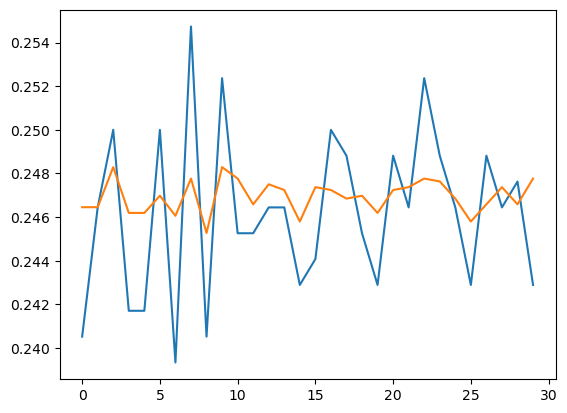

avg_loss 1.4005979980741228
accuracy 0.22799097065462753
Shape of X after subsampling and concatenating: (7616, 22, 100)
Shape of Y: (7616,)
Shape of X after subsampling and concatenating: (844, 22, 100)
Shape of Y: (844,)
val split:  844
train split:  7616
torch.Size([1, 22, 100])
torch.Size([1, 18, 100])


Epoch 1/30: 100%|██████████| 119/119 [00:04<00:00, 26.62it/s, loss=1.41]


Validation set: Average loss = 1.4079, Accuracy = 0.2227
Training set: Average loss = 1.4124, Accuracy = 0.2218


Epoch 2/30: 100%|██████████| 119/119 [00:05<00:00, 22.42it/s, loss=1.47]


Validation set: Average loss = 1.4081, Accuracy = 0.2227
Training set: Average loss = 1.4126, Accuracy = 0.2212


Epoch 3/30: 100%|██████████| 119/119 [00:04<00:00, 24.99it/s, loss=1.45]


Validation set: Average loss = 1.4084, Accuracy = 0.2227
Training set: Average loss = 1.4129, Accuracy = 0.2223


Epoch 4/30: 100%|██████████| 119/119 [00:05<00:00, 22.50it/s, loss=1.48]


Validation set: Average loss = 1.4081, Accuracy = 0.2227
Training set: Average loss = 1.4126, Accuracy = 0.2222


Epoch 5/30: 100%|██████████| 119/119 [00:03<00:00, 31.29it/s, loss=1.5] 


Validation set: Average loss = 1.4084, Accuracy = 0.2227
Training set: Average loss = 1.4129, Accuracy = 0.2212


Epoch 6/30: 100%|██████████| 119/119 [00:03<00:00, 32.84it/s, loss=1.41]


Validation set: Average loss = 1.4083, Accuracy = 0.2216
Training set: Average loss = 1.4127, Accuracy = 0.2226


Epoch 7/30: 100%|██████████| 119/119 [00:03<00:00, 36.95it/s, loss=1.44]


Validation set: Average loss = 1.4082, Accuracy = 0.2216
Training set: Average loss = 1.4127, Accuracy = 0.2209


Epoch 8/30: 100%|██████████| 119/119 [00:03<00:00, 36.05it/s, loss=1.45]


Validation set: Average loss = 1.4079, Accuracy = 0.2227
Training set: Average loss = 1.4123, Accuracy = 0.2216


Epoch 9/30: 100%|██████████| 119/119 [00:03<00:00, 33.85it/s, loss=1.44]


Validation set: Average loss = 1.4083, Accuracy = 0.2227
Training set: Average loss = 1.4128, Accuracy = 0.2211


Epoch 10/30: 100%|██████████| 119/119 [00:03<00:00, 39.19it/s, loss=1.45]


Validation set: Average loss = 1.4080, Accuracy = 0.2227
Training set: Average loss = 1.4125, Accuracy = 0.2216


Epoch 11/30: 100%|██████████| 119/119 [00:02<00:00, 41.63it/s, loss=1.46]


Validation set: Average loss = 1.4083, Accuracy = 0.2227
Training set: Average loss = 1.4128, Accuracy = 0.2205


Epoch 12/30: 100%|██████████| 119/119 [00:02<00:00, 41.00it/s, loss=1.41]


Validation set: Average loss = 1.4078, Accuracy = 0.2227
Training set: Average loss = 1.4123, Accuracy = 0.2222


Epoch 13/30: 100%|██████████| 119/119 [00:03<00:00, 36.76it/s, loss=1.44]


Validation set: Average loss = 1.4082, Accuracy = 0.2227
Training set: Average loss = 1.4126, Accuracy = 0.2210


Epoch 14/30: 100%|██████████| 119/119 [00:02<00:00, 41.95it/s, loss=1.4] 


Validation set: Average loss = 1.4079, Accuracy = 0.2239
Training set: Average loss = 1.4123, Accuracy = 0.2226


Epoch 15/30: 100%|██████████| 119/119 [00:03<00:00, 33.12it/s, loss=1.45]


Validation set: Average loss = 1.4081, Accuracy = 0.2227
Training set: Average loss = 1.4125, Accuracy = 0.2215


Epoch 16/30: 100%|██████████| 119/119 [00:03<00:00, 32.85it/s, loss=1.45]


Validation set: Average loss = 1.4080, Accuracy = 0.2227
Training set: Average loss = 1.4125, Accuracy = 0.2223


Epoch 17/30: 100%|██████████| 119/119 [00:03<00:00, 32.45it/s, loss=1.4] 


Validation set: Average loss = 1.4080, Accuracy = 0.2227
Training set: Average loss = 1.4125, Accuracy = 0.2215


Epoch 18/30: 100%|██████████| 119/119 [00:04<00:00, 26.67it/s, loss=1.41]


Validation set: Average loss = 1.4083, Accuracy = 0.2227
Training set: Average loss = 1.4127, Accuracy = 0.2211


Epoch 19/30: 100%|██████████| 119/119 [00:04<00:00, 27.19it/s, loss=1.36]


Validation set: Average loss = 1.4082, Accuracy = 0.2227
Training set: Average loss = 1.4126, Accuracy = 0.2209


Epoch 20/30: 100%|██████████| 119/119 [00:04<00:00, 28.76it/s, loss=1.4] 


Validation set: Average loss = 1.4081, Accuracy = 0.2239
Training set: Average loss = 1.4126, Accuracy = 0.2210


Epoch 21/30: 100%|██████████| 119/119 [00:05<00:00, 22.81it/s, loss=1.43]


Validation set: Average loss = 1.4082, Accuracy = 0.2216
Training set: Average loss = 1.4127, Accuracy = 0.2209


Epoch 22/30: 100%|██████████| 119/119 [00:05<00:00, 23.23it/s, loss=1.47]


Validation set: Average loss = 1.4079, Accuracy = 0.2227
Training set: Average loss = 1.4124, Accuracy = 0.2216


Epoch 23/30: 100%|██████████| 119/119 [00:04<00:00, 26.27it/s, loss=1.44]


Validation set: Average loss = 1.4077, Accuracy = 0.2239


In [12]:
for timestop in range(100, 1050, 50):

      # @title Data loading
      data_root = "../project_data/project/"
      if GOOGLE:
            data_root = "/content/drive/MyDrive/project/"
      data_transform =  lambda x: (x.reshape(1, x.shape[0],x.shape[1]))
      preprocess = lambda x,y:train_data_prep(x,y,2,2,True, timestop)
      # Create eeg dataset object
      eeg_train = EEG_Data(data_root,
                                    split='train',
                                    preprocess=preprocess,
                                    transform=data_transform)

      eeg_val = EEG_Data(data_root,
                              split='val',
                              preprocess=preprocess,
                              transform=data_transform)
      eeg_test = EEG_Data(data_root,
                              split='test',
                              preprocess=lambda x:test_data_prep(x, 2, timestop),
                              transform=data_transform)
      print("val split: ", len(eeg_val))
      print("train split: ", len(eeg_train))
      print(eeg_train[0][0].shape)
      print(eeg_train[0][0][:,0:18,:].shape)
      # Create the dataloaders
      # Define the batch size and number of workers
      batch_size = 64
      num_workers=2
      # Create DataLoader for training and validation sets
      train_loader = DataLoader(eeg_train,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=True)
      val_loader = DataLoader(eeg_val,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=False)
      test_loader = DataLoader(eeg_test,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=False)

      seed_everything(0)

      model = EEGNet(timestop=timestop)

      model.to(device)

      # Let's test_loaderss function, your implementation and the built-in loss function should
      # be almost identical.
      criterion = nn.CrossEntropyLoss()
      # Train the model
      loss_history_train, loss_history_val = train(model,
            train_loader,
            val_loader,
            optimizer,
            criterion,
            device,
            num_epochs=30)
      all_result[timestop] = [loss_history_train, loss_history_val]
      avg_loss, accuracy = evaluate(model, test_loader, criterion, device)

      print("avg_loss", avg_loss)
      print("accuracy", accuracy)



In [ ]:

avg_loss, accuracy = evaluate(model, test_loader, criterion, device)

print("avg_loss", avg_loss)
print("accuracy", accuracy)


avg_loss 0.8216522761753627
accuracy 0.7110609480812641
